
--- Feature Preparation Summary ---
Original Rows: 19275
Rows after cleaning: 19275
Columns used: temperature, windspeed, humidity, precipitation, dewpoint, cloud_cover, pressure, solar_radiation, sunshine_duration, ndvi, elevation
Epoch 1/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.4133 - val_loss: 0.7617
Epoch 2/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7158 - val_loss: 0.6147
Epoch 3/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6115 - val_loss: 0.5717
Epoch 4/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5664 - val_loss: 0.5342
Epoch 5/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5285 - val_loss: 0.5076
Epoch 6/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5032 - val_loss: 0.4888
Epoch 7/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4884 - val_loss: 0.4786
Epoch 8/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4784 - val_loss: 0.4655
Epoch 9/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4699 - v

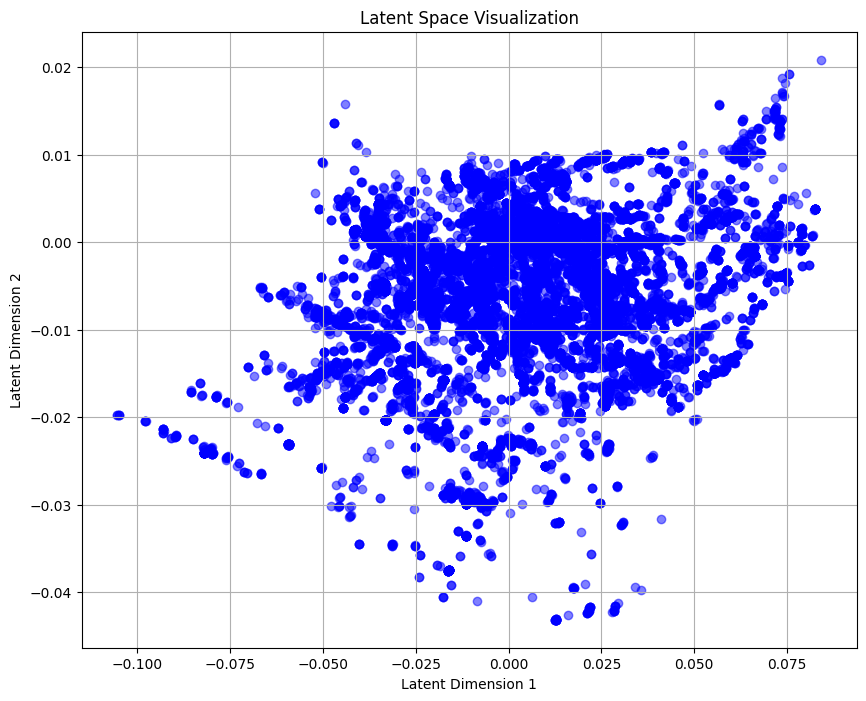

In [46]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
import pickle
import matplotlib.pyplot as plt

def prepare_environmental_features(df):
    """
    Prepare environmental features for VAE analysis
    
    Parameters:
    - df: Input DataFrame
    
    Returns:
    - DataFrame with selected environmental features
    """
    # Select specific environmental columns
    environmental_columns = [
        'temperature', 'windspeed', 'humidity', 'precipitation',
        'dewpoint', 'cloud_cover', 'pressure', 'solar_radiation', 
        'sunshine_duration', 'ndvi', 'elevation'
    ]
    
    # Ensure all columns exist
    available_columns = [col for col in environmental_columns if col in df.columns]
    
    if not available_columns:
        raise ValueError("No environmental columns found in the dataset")
    
    # Create a copy of the selected columns
    feature_df = df[available_columns].copy()
    
    # Convert to numeric, coercing errors
    feature_df = feature_df.apply(pd.to_numeric, errors='coerce')
    
    # Remove rows with NaN values
    feature_df = feature_df.dropna()
    
    # Descriptive statistics
    print("\n--- Feature Preparation Summary ---")
    print(f"Original Rows: {len(df)}")
    print(f"Rows after cleaning: {len(feature_df)}")
    print(f"Columns used: {', '.join(available_columns)}")
    
    return feature_df

def create_vae(input_dim, latent_dim=16):
    """
    Create a Variational Autoencoder (VAE) model.
    """
    # Encoder
    inputs = tf.keras.layers.Input(shape=(input_dim,))
    
    # Encoder layers
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    # Latent space
    z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)
    
    # Sampling function
    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.keras.backend.shape(z_mean)[0]
        epsilon = tf.keras.backend.random_normal(shape=(batch, latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    # Sampling layer
    z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    
    # Encoder model
    encoder = tf.keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
    
    # Decoder
    latent_inputs = tf.keras.layers.Input(shape=(latent_dim,))
    
    # Decoder layers
    y = tf.keras.layers.Dense(32, activation='relu')(latent_inputs)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Dropout(0.2)(y)
    
    y = tf.keras.layers.Dense(64, activation='relu')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Dropout(0.2)(y)
    
    outputs = tf.keras.layers.Dense(input_dim, activation='linear')(y)
    
    # Decoder model
    decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')
    
    # Custom VAE loss
    def vae_loss(inputs, reconstructed, z_mean, z_log_var):
        # Reconstruction loss (Mean Squared Error)
        reconstruction_loss = tf.reduce_mean(tf.square(inputs - reconstructed))
        
        # KL Divergence loss
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )
        
        # Combine losses
        return reconstruction_loss + kl_loss
    
    # VAE model
    @tf.keras.utils.register_keras_serializable()
    class VAE(tf.keras.Model):
        def __init__(self, encoder, decoder, **kwargs):
            super(VAE, self).__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder
        
        def call(self, inputs):
            # Encode
            z_mean, z_log_var, z = self.encoder(inputs)
            
            # Decode
            reconstructed = self.decoder(z)
            
            # Calculate and track the loss
            self.add_loss(vae_loss(inputs, reconstructed, z_mean, z_log_var))
            
            return reconstructed

        def get_config(self):
            config = super(VAE, self).get_config()
            config.update({
                'encoder': self.encoder,
                'decoder': self.decoder
            })
            return config

        @classmethod
        def from_config(cls, config):
            encoder = config.pop('encoder')
            decoder = config.pop('decoder')
            return cls(encoder, decoder, **config)
    # Create VAE model
    vae = VAE(encoder, decoder)
    
    # Compile VAE
    vae.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse'  # Using MSE as a fallback, but the custom loss is in the model
    )
    
    return vae, encoder, decoder

def train_anomaly_detection_vae(data):
    """
    Train VAE for anomaly detection
    """
    try:
        # Prepare data
        feature_data = prepare_environmental_features(data)
        
        # Scale the data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(feature_data.values)
        
        # Split data
        X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)
        
        # Create VAE
        input_dim = X_scaled.shape[1]
        vae, encoder, decoder = create_vae(input_dim)
        
        # Callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='loss', 
            patience=15, 
            restore_best_weights=True
        )
        
        # Train VAE
        history = vae.fit(
            X_train, X_train,
            epochs=100,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=1
        )
        
        # Reconstruct data
        train_reconstructed = vae.predict(X_train)
        test_reconstructed = vae.predict(X_test)
        
        # Compute reconstruction error (MSE)
        train_mse = np.mean(np.power(X_train - train_reconstructed, 2), axis=1)
        test_mse = np.mean(np.power(X_test - test_reconstructed, 2), axis=1)
        
        # Anomaly threshold (e.g., 95th percentile of reconstruction error)
        anomaly_threshold = np.percentile(train_mse, 95)
        
        print(f"\nAnomaly Detection Threshold: {anomaly_threshold}")
        print(f"Potential Anomalies in Test Set: {np.sum(test_mse > anomaly_threshold)}")
        
        # Save models and results
        os.makedirs("models", exist_ok=True)
        vae.save("models/environmental_vae.keras")
        encoder.save("models/environmental_encoder.keras")
        decoder.save("models/environmental_decoder.keras")
        
        with open("models/vae_scaler.pkl", "wb") as f:
            pickle.dump(scaler, f)

        with open("models/anomaly_threshold.pkl", "wb") as f:
            pickle.dump(anomaly_threshold, f)
        
        # Latent space visualization
        z_mean, _, _ = encoder.predict(X_scaled)  # Get the mean of the latent space
        plt.figure(figsize=(10, 8))
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c='blue', alpha=0.5)
        plt.title('Latent Space Visualization')
        plt.xlabel('Latent Dimension 1')
        plt.ylabel('Latent Dimension 2')
        plt.grid()
        plt.show()
        
        return {
            'vae': vae,
            'encoder': encoder,
            'decoder': decoder,
            'scaler': scaler,
            'anomaly_threshold': anomaly_threshold,
            'train_mse': train_mse,
            'test_mse': test_mse
        }
    
    except Exception as e:
        print(f"Error in VAE training: {e}")
        return None
    

def main():
    """
    Main execution function
    """
    # Load dataset
    df = pd.read_excel("og.xlsx")
    
    # Train VAE for anomaly detection
    vae_model = train_anomaly_detection_vae(df)
    
    return vae_model

if __name__ == "__main__":
    main()

In [49]:
import numpy as np
import tensorflow as tf
import pickle
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian."""
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def compute_similarity(test_data, encoder, decoder, scaler, threshold):
    """
    Compute similarity of test samples based on reconstruction error and latent space proximity.
    
    Parameters:
    - test_data: Input test dataset
    - encoder: Trained encoder model
    - decoder: Trained decoder model
    - scaler: Fitted StandardScaler
    - threshold: Anomaly detection threshold
    
    Returns:
    - similarity_scores: Similarity scores for the test samples
    - anomalies: Boolean array indicating anomalies
    """
    try:
        # Scale test data
        X_test_scaled = scaler.transform(test_data.values)
        
        # Get latent representations
        z_mean_test, z_log_var_test = encoder.predict(X_test_scaled)
        z_test = sampling((z_mean_test, z_log_var_test))
        
        # Reconstruct data using decoder
        reconstructed_test = decoder.predict(z_test)
        
        # Compute reconstruction error (MSE)
        test_mse = np.mean(np.power(X_test_scaled - reconstructed_test, 2), axis=1)
        
        # Similarity score: Normalize (higher means more normal, lower means anomaly)
        max_mse = np.max(test_mse)
        similarity_scores = 1 - (test_mse / max_mse)
        
        # Identify anomalies
        anomalies = test_mse > threshold
        
        print(f"\nSimilarity Analysis Completed:")
        print(f"Average Similarity Score: {np.mean(similarity_scores):.4f}")
        print(f"Detected Anomalies: {np.sum(anomalies)} out of {len(test_data)} samples")
        
        return similarity_scores, anomalies
    except Exception as e:
        print(f"Error in similarity computation: {e}")
        return None, None

if __name__ == "__main__":
    # Load test dataset
    df_test = pd.read_excel("ogtest.xlsx")
    environmental_columns = [
        'temperature', 'windspeed', 'humidity', 'precipitation',
        'dewpoint', 'cloud_cover', 'pressure', 'solar_radiation', 
        'sunshine_duration', 'ndvi', 'elevation'
    ]
    df_test=df_test[environmental_columns]
    
    # Load trained models
    custom_objects = {"sampling": sampling}
    encoder = tf.keras.models.load_model("models/environmental_encoder.keras", custom_objects=custom_objects)
    decoder = tf.keras.models.load_model("models/environmental_decoder.keras")
    
    with open("models/vae_scaler.pkl", "rb") as f:
        scaler = pickle.load(f)
    
    # Load anomaly detection threshold
    with open("models/vae_scaler.pkl", "rb") as f:
        anomaly_threshold = pickle.load(f)
    
    # Compute similarity and detect anomalies
    similarity_scores, anomalies = compute_similarity(df_test, encoder, decoder, scaler, anomaly_threshold)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Error in similarity computation: too many values to unpack (expected 2)
